# Estatística

Considerando a base de dados _experimento_test_ab.csv_ responda as
questões abaixo:

<b>1.</b> Qual dos cenários tem a maior taxa de conversão?<br>
<b>2.</b> Calcule qual o tamanho da amostra necessária para o desenvolvimento de um teste A/B, seguindo os seguintes critérios:
  1. O cenário A, da base, como o inicial, que funciona hoje
  2. Considere 95% de confiança de que o efeito na conversão não foi aleatório com um nível de significância de 5% (alpha = 0,05)
  3. Também considere 80% de certeza conseguir capturar o efeito da nova abordagem
  4. O aumento para 10% de conversão

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import ttest_ind
import numpy as np

In [2]:
df = pd.read_csv('experimento_teste_ab.csv')
df.head(3)

,Visitante_ID,Versão_Página,Visualizações,Conversões
0,1,A,167,1
1,2,A,160,0
2,3,A,170,0


Analises Iniciais

In [41]:
print(df.info())
print('\n****FORMATO****\n{} linhas\n{} colunas'.format(df.shape[0],df.shape[1]))
print('\n****CONTROLE E TESTE****\n{}'.format(df['Versão_Página'].value_counts()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Visitante_ID   2000 non-null   int64 
 1   Versão_Página  2000 non-null   object
 2   Visualizações  2000 non-null   int64 
 3   Conversões     2000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.6+ KB
None

****FORMATO****
2000 linhas
4 colunas

****CONTROLE E TESTE****
A    1000
B    1000
Name: Versão_Página, dtype: int64


In [4]:
df_a = df.loc[df['Versão_Página'] == 'A'] 
df_b = df.loc[df['Versão_Página'] == 'B']

In [60]:
describe1 = df_a[['Visualizações','Conversões']].describe().reset_index()
describe1 = describe1.rename(columns={'Visualizações':'Controle Visualizações','Conversões':'Controle Conversões'})

describe2 = df_b[['Visualizações','Conversões']].describe().reset_index()
describe2 = describe2.rename(columns={'Visualizações':'Teste Visualizações','Conversões':'Teste Conversões'}).drop(['index'], axis=1)

describe = pd.concat([describe1, describe2], axis=1).drop([0],axis=0)
describe

,index,Controle Visualizações,Controle Conversões,Teste Visualizações,Teste Conversões
1,mean,150.835000,0.105000,150.676000,0.125000
2,std,28.951372,0.306707,28.681033,0.330884
3,min,100.000000,0.000000,100.000000,0.000000
4,25%,126.000000,0.000000,126.000000,0.000000
5,50%,152.000000,0.000000,150.000000,0.000000
6,75%,176.000000,0.000000,175.000000,0.000000
7,max,199.000000,1.000000,199.000000,1.000000


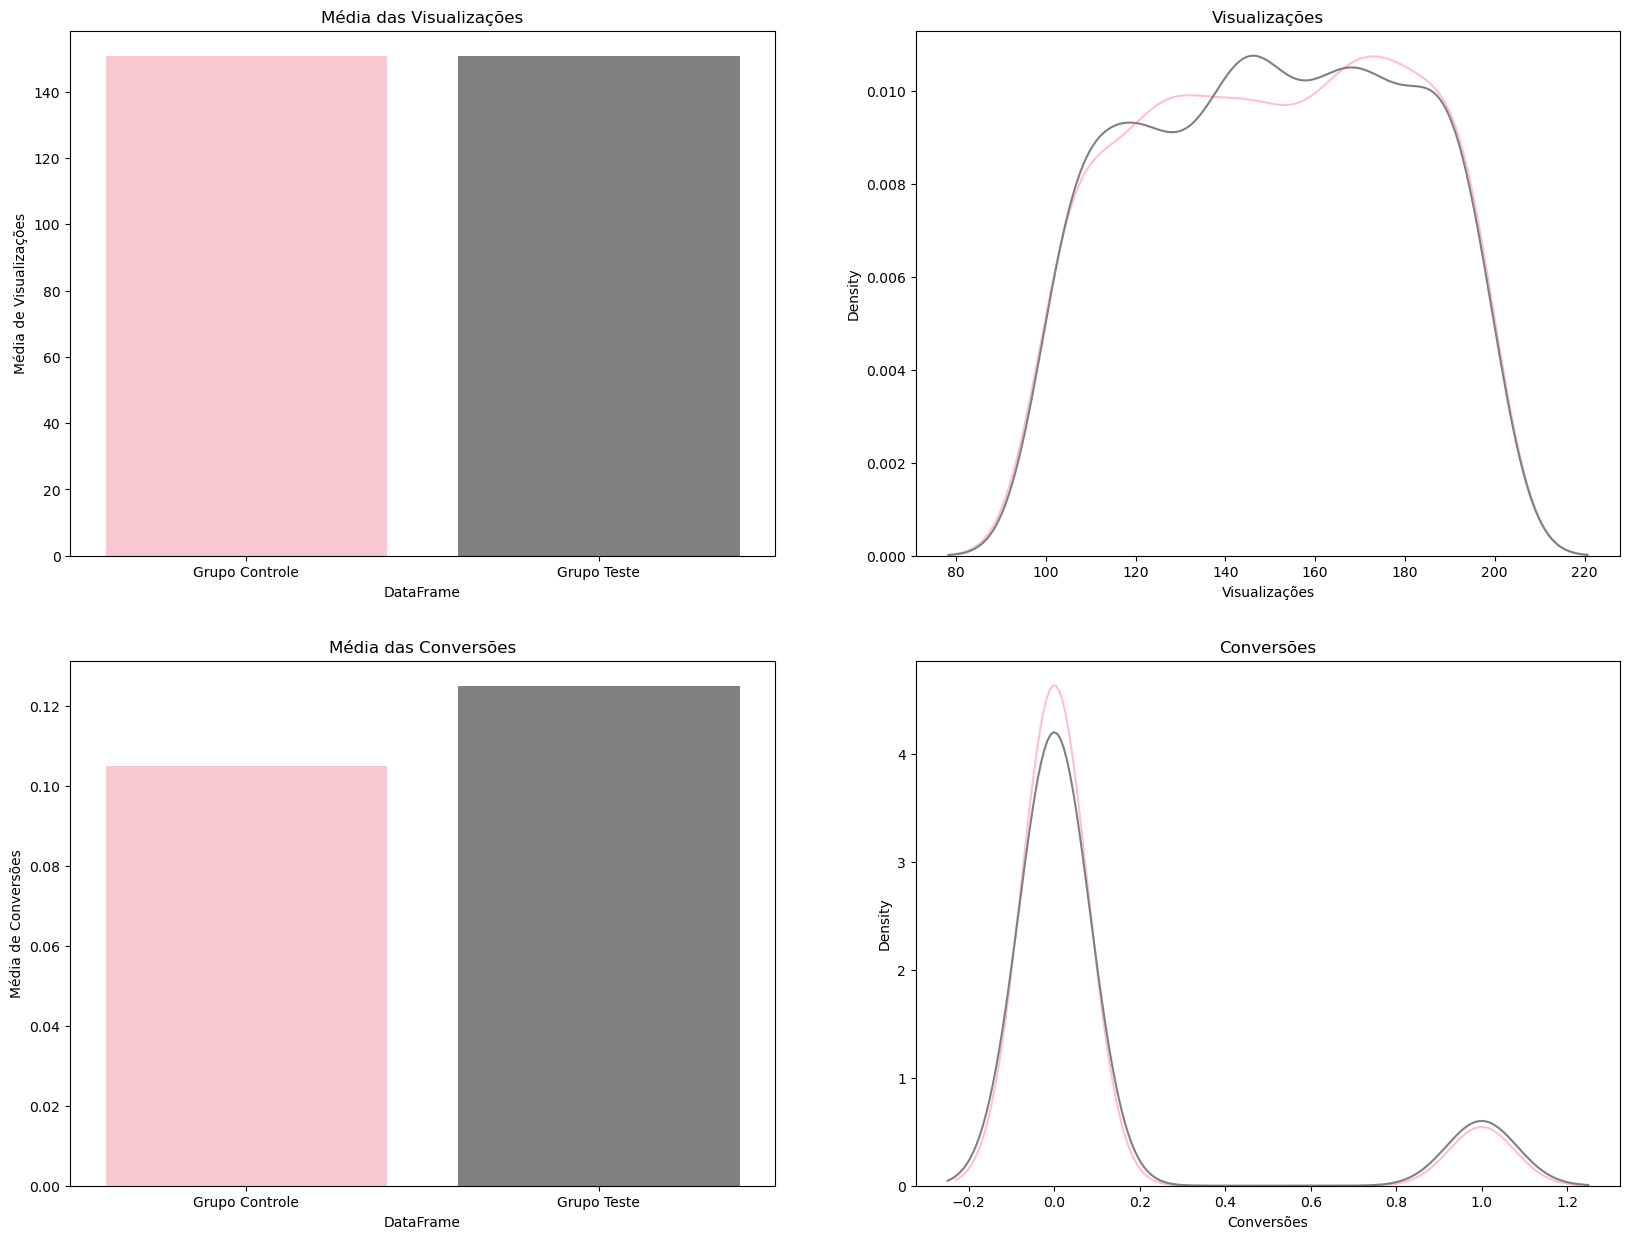

In [232]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

#-----------------------------------------------------------------------------------#

media_a = df_a['Visualizações'].mean()
media_b = df_b['Visualizações'].mean()

dados = {'DataFrame': ['Grupo Controle', 'Grupo Teste'],
         'Média de Visualizações': [media_a, media_b]}
df_media1 = pd.DataFrame(dados)
#-----------------------------------------------------------------------------------#

media_a_conversoes = df_a['Conversões'].mean()
media_b_conversoes = df_b['Conversões'].mean()

dados2 = {'DataFrame': ['Grupo Controle', 'Grupo Teste'],
         'Média de Conversões': [media_a_conversoes, media_b_conversoes]}


df_media2 = pd.DataFrame(dados2)
#-----------------------------------------------------------------------------------#


sns.barplot(x='DataFrame', y='Média de Visualizações', data=df_media1, palette=['pink', 'gray'], ax=ax[0,0])
ax[0,0].set_title('Média das Visualizações')

#
sns.kdeplot(df_a['Visualizações'],ax=ax[0,1], color='pink')
sns.kdeplot(df_b['Visualizações'], ax=ax[0,1], color='gray')
ax[0,1].set_title('Visualizações')

#
sns.barplot(x='DataFrame', y='Média de Conversões', data=df_media2, palette=['pink', 'gray'], ax=ax[1,0])
ax[1,0].set_title('Média das Conversões')

#
sns.kdeplot(df_a['Conversões'],ax=ax[1,1], color='pink')
sns.kdeplot(df_b['Conversões'], ax=ax[1,1], color='gray')
ax[1,1].set_title('Conversões')



#-----------------------------------------------------------------------------------#
plt.show()

### Insights 💡
Com o describe dos grupos, podemos notar um aumento de 19% na conversão para o grupo de Teste.

Apesar da média de visualizações dos dois grupos praticamente iguais, observamos que a conversão do grupo B de teste é um pouco maior em relação ao grupo A, isso sugere que ambos os grupos tiveram oportunidades aproximadamente iguais de atrair interesse, mas houve essa retenção a mais de clientes pelo grupo de teste. Podemos testar essa afirmação com base no Conversion Rate, logo abaixo.

In [26]:
cr_a = (df_a['Conversões'].sum()) / (df_a['Visualizações'].sum())
cr_b = (df_b['Conversões'].sum()) / (df_b['Visualizações'].sum())
dict_cr = {'Grupo':['Controle (A)','Teste (B)'],'Conversion Rate':[cr_a,cr_b]}
cr = pd.DataFrame(dict_cr)
print("Aumento da taxa de conversão: {:.2f}%".format(((cr_b - cr_a)/cr_a) * 100))
cr

Aumento da taxa de conversão: 19.17%


,Grupo,Conversion Rate
0,Controle (A),0.000696
1,Teste (B),0.000830


# Tamanho amostral

  1. O cenário A, da base, como o inicial, que funciona hoje
  2. Considere 95% de confiança de que o efeito na conversão não foi aleatório com um nível de significância de 5% (alpha = 0,05)
  3. Também considere 80% de certeza conseguir capturar o efeito da nova abordagem
  4. O aumento para 10% de conversão

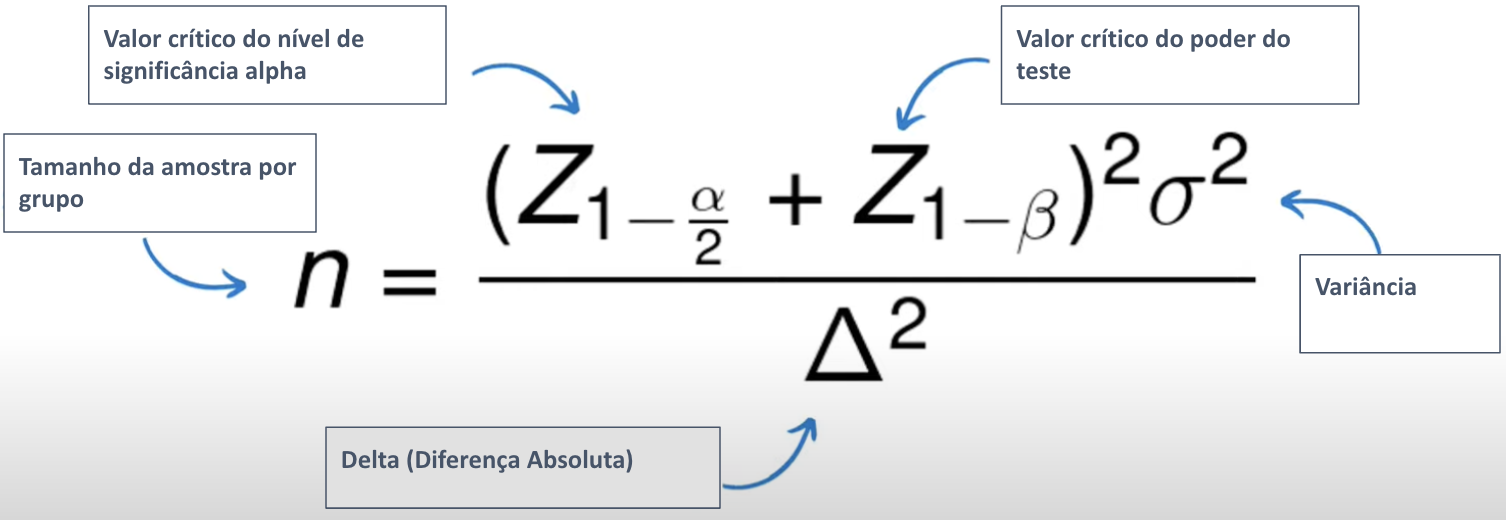

In [35]:
# DELTA CALCULO

cr_alvo = 0.10 #10%

delta = cr_alvo - cr_a
delta

0.09930387509530282

In [38]:
z_alpha = 1.96
z_beta = 0.8
var = df_a['Conversões'].std() * df_a['Conversões'].std()

In [40]:
n = round((((z_alpha + z_beta)**2) * (2 * var))/delta**2)
print("Tamanho de amostra necessária para cada grupo: ",n)

Tamanho de amostra necessária para cada grupo:  145
